In [1]:
import math
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns  
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
import sklearn.preprocessing
from sklearn.feature_selection import SelectKBest, f_regression, chi2, RFE
from env import username, host, password
import wrangle, acquire, prepare, explore, evaluate

In [2]:
zillow_df = wrangle.wrangle_zillow()

In [3]:
zillow_df.isnull().sum()

parcelid     0
bed          0
bath         0
sqft         0
tax_value    0
yearbuilt    0
taxamount    0
fips         0
dtype: int64

In [4]:
zillow_df.describe().T

,count,mean,std,min,25%,50%,75%,max
parcelid,28026.0,1.302654e+07,3.523613e+06,10711855.00,1.151072e+07,1.259204e+07,1.414731e+07,1.676392e+08
bed,28026.0,3.314672e+00,9.306345e-01,0.00,3.000000e+00,3.000000e+00,4.000000e+00,1.200000e+01
bath,28026.0,2.319739e+00,1.012109e+00,0.00,2.000000e+00,2.000000e+00,3.000000e+00,1.100000e+01
sqft,28026.0,1.933838e+03,9.928167e+02,240.00,1.278000e+03,1.674000e+03,2.325000e+03,1.724500e+04
tax_value,28026.0,5.331635e+05,7.034293e+05,1000.00,1.986170e+05,3.823390e+05,6.318152e+05,2.385837e+07
yearbuilt,28026.0,1.963783e+03,2.309993e+01,1878.00,1.950000e+03,1.961000e+03,1.979000e+03,2.016000e+03
taxamount,28026.0,6.487169e+03,8.164871e+03,51.26,2.704932e+03,4.734715e+03,7.520265e+03,2.767978e+05
fips,28026.0,6.049451e+03,2.122804e+01,6037.00,6.037000e+03,6.037000e+03,6.059000e+03,6.111000e+03


In [5]:
# fips codes are unique county codes, there are 3 different counties here. Perhaps a driver?
zillow_df.fips.unique()

array([6037., 6059., 6111.])

6037 = LA county
6059 = Orange county
6111 = Ventura county
according to https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697

In [6]:
zillow_df['county'] = zillow_df['fips'].replace(to_replace = [6037, 6059, 6111], value = ['LA','Orange','Ventura'])

In [7]:
zillow_df

,parcelid,bed,bath,sqft,tax_value,yearbuilt,taxamount,fips,county
0,11721753,3.0,2.0,1316.0,205123.0,1923.0,2627.48,6037.0,LA
1,11289917,3.0,2.0,1458.0,136104.0,1970.0,2319.90,6037.0,LA
2,11705026,2.0,1.0,1421.0,35606.0,1911.0,543.69,6037.0,LA
3,14269464,4.0,3.0,2541.0,880456.0,2003.0,9819.72,6059.0,Orange
4,11446756,3.0,2.0,1491.0,107110.0,1955.0,1399.27,6037.0,LA
...,...,...,...,...,...,...,...,...,...
28119,11991766,6.0,2.0,2634.0,878190.0,1921.0,12766.88,6037.0,LA
28120,14011468,4.0,1.5,1187.0,465999.0,1959.0,5552.68,6059.0,Orange
28121,14453399,5.0,3.0,3015.0,852813.0,2002.0,11662.88,6059.0,Orange
28122,11128688,5.0,3.0,2992.0,1120000.0,1977.0,13663.03,6037.0,LA


In [8]:
zillow_df['tax_rate'] = zillow_df['taxamount']/zillow_df['tax_value']

In [9]:
zillow_df.describe().apply(lambda x: x.apply('{0:.2f}'.format)).T

,count,mean,std,min,25%,50%,75%,max
parcelid,28026.00,13026537.05,3523612.83,10711855.00,11510720.50,12592035.00,14147310.25,167639152.00
bed,28026.00,3.31,0.93,0.00,3.00,3.00,4.00,12.00
bath,28026.00,2.32,1.01,0.00,2.00,2.00,3.00,11.00
sqft,28026.00,1933.84,992.82,240.00,1278.00,1674.00,2325.00,17245.00
tax_value,28026.00,533163.52,703429.34,1000.00,198617.00,382339.00,631815.25,23858374.00
yearbuilt,28026.00,1963.78,23.10,1878.00,1950.00,1961.00,1979.00,2016.00
taxamount,28026.00,6487.17,8164.87,51.26,2704.93,4734.72,7520.26,276797.83
fips,28026.00,6049.45,21.23,6037.00,6037.00,6037.00,6059.00,6111.00
tax_rate,28026.00,0.01,0.01,0.00,0.01,0.01,0.01,0.82


In [10]:
# check the min values on tax rate to get a look at weird values
zillow_df[zillow_df['tax_value'] == zillow_df['tax_value'].min()]

,parcelid,bed,bath,sqft,tax_value,yearbuilt,taxamount,fips,county,tax_rate
20876,11137835,3.0,4.0,3284.0,1000.0,1985.0,816.49,6037.0,LA,0.81649


In [11]:
# do the same with max
zillow_df[zillow_df['tax_value'] == zillow_df['tax_value'].max()]

,parcelid,bed,bath,sqft,tax_value,yearbuilt,taxamount,fips,county,tax_rate
3482,11638822,7.0,5.0,8790.0,23858374.0,1926.0,276797.83,6037.0,LA,0.011602


In [12]:
zillow_df['zscore'] = stats.zscore(zillow_df['tax_value'])
zillow_df

,parcelid,bed,bath,sqft,tax_value,yearbuilt,taxamount,fips,county,tax_rate,zscore
0,11721753,3.0,2.0,1316.0,205123.0,1923.0,2627.48,6037.0,LA,0.012809,-0.466353
1,11289917,3.0,2.0,1458.0,136104.0,1970.0,2319.90,6037.0,LA,0.017045,-0.564473
2,11705026,2.0,1.0,1421.0,35606.0,1911.0,543.69,6037.0,LA,0.015270,-0.707344
3,14269464,4.0,3.0,2541.0,880456.0,2003.0,9819.72,6059.0,Orange,0.011153,0.493722
4,11446756,3.0,2.0,1491.0,107110.0,1955.0,1399.27,6037.0,LA,0.013064,-0.605691
...,...,...,...,...,...,...,...,...,...,...,...
28119,11991766,6.0,2.0,2634.0,878190.0,1921.0,12766.88,6037.0,LA,0.014538,0.490501
28120,14011468,4.0,1.5,1187.0,465999.0,1959.0,5552.68,6059.0,Orange,0.011916,-0.095483
28121,14453399,5.0,3.0,3015.0,852813.0,2002.0,11662.88,6059.0,Orange,0.013676,0.454424
28122,11128688,5.0,3.0,2992.0,1120000.0,1977.0,13663.03,6037.0,LA,0.012199,0.834266


In [13]:
# removes outliers
zillow_df = zillow_df[(np.abs(stats.zscore(zillow_df['tax_value'])) < 3)]
zillow_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27617 entries, 0 to 28123
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   parcelid   27617 non-null  int64  
 1   bed        27617 non-null  float64
 2   bath       27617 non-null  float64
 3   sqft       27617 non-null  float64
 4   tax_value  27617 non-null  float64
 5   yearbuilt  27617 non-null  float64
 6   taxamount  27617 non-null  float64
 7   fips       27617 non-null  float64
 8   county     27617 non-null  object 
 9   tax_rate   27617 non-null  float64
 10  zscore     27617 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 2.5+ MB


In [14]:
zillow_df.describe().apply(lambda x: x.apply('{0:.2f}'.format)).T

,count,mean,std,min,25%,50%,75%,max
parcelid,27617.00,13034787.36,3545074.67,10711855.00,11503331.00,12606905.00,14149013.00,167639152.00
bed,27617.00,3.30,0.92,0.00,3.00,3.00,4.00,12.00
bath,27617.00,2.28,0.95,0.00,2.00,2.00,3.00,10.00
sqft,27617.00,1889.04,883.33,240.00,1273.00,1660.00,2288.00,11020.00
tax_value,27617.00,474910.20,408708.68,1000.00,195981.00,376813.00,615002.00,2642313.00
yearbuilt,27617.00,1963.58,22.95,1878.00,1950.00,1961.00,1979.00,2016.00
taxamount,27617.00,5820.45,4770.37,51.26,2675.83,4668.36,7322.89,61992.63
fips,27617.00,6049.53,21.30,6037.00,6037.00,6037.00,6059.00,6111.00
tax_rate,27617.00,0.01,0.01,0.00,0.01,0.01,0.01,0.82
zscore,27617.00,-0.08,0.58,-0.76,-0.48,-0.22,0.12,3.00


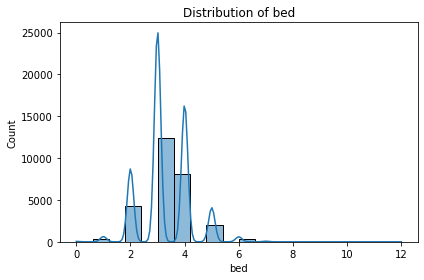

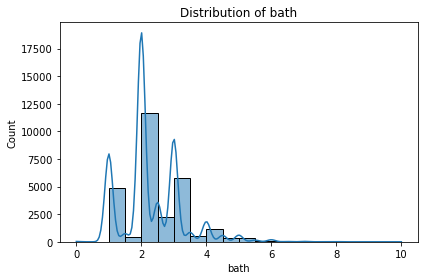

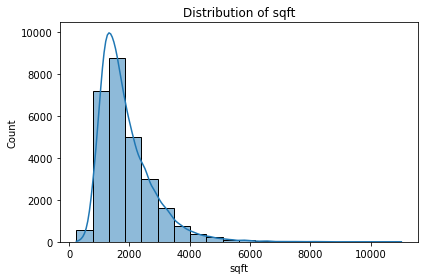

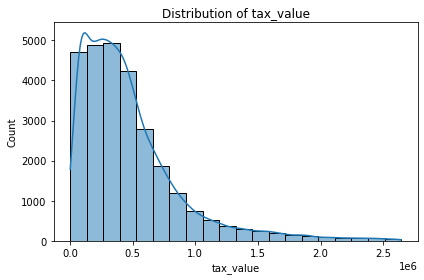

In [15]:
# loop it for distributions
for x in zillow_df[['bed','bath','sqft','tax_value']]:
    sns.histplot(zillow_df[x], bins = 20, kde = True)
    plt.title(f'Distribution of {x}')
    plt.tight_layout()
    plt.show()

In [16]:
train,validate,test = prepare.train_validate_test_split(zillow_df)

In [17]:
X_train = train[['bed','bath','sqft']]
X_validate = validate[['bed','bath','sqft']]
X_test = test[['bed','bath','sqft']]
y_train = pd.DataFrame(train['tax_value'])
y_validate = pd.DataFrame(validate['tax_value'])
y_test = pd.DataFrame(test['tax_value'])

In [18]:
X_train_scaled = prepare.minmax_scale(X_train, X_train)
X_validate_scaled = prepare.minmax_scale(X_validate, X_train)
X_test_scaled = prepare.minmax_scale(X_test, X_train)

In [19]:
X_train_scaled['county'] = train['county'].reset_index(drop = True)

<AxesSubplot:>

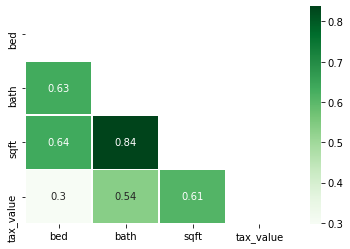

In [20]:
explore.heat_corr(train[['bed','bath','sqft','tax_value']])

<AxesSubplot:xlabel='sqft'>

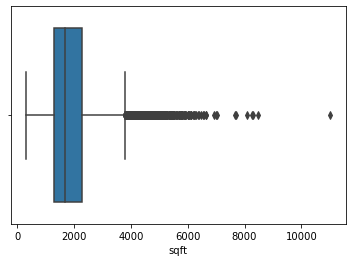

In [21]:
sns.boxplot(train['sqft'])

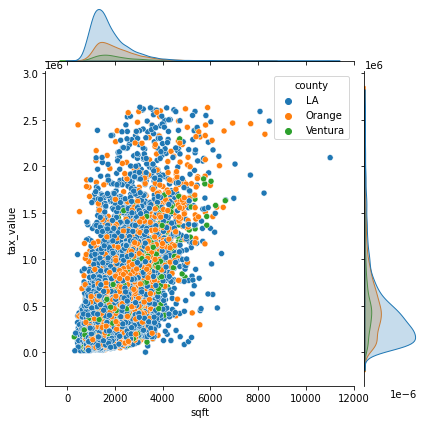

In [22]:
sns.jointplot(x = 'sqft', y = 'tax_value', data = train, hue = 'county')

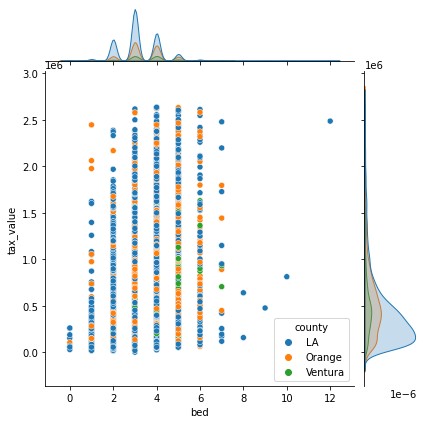

In [23]:
sns.jointplot(x = 'bed', y = 'tax_value', data = train, hue = 'county')

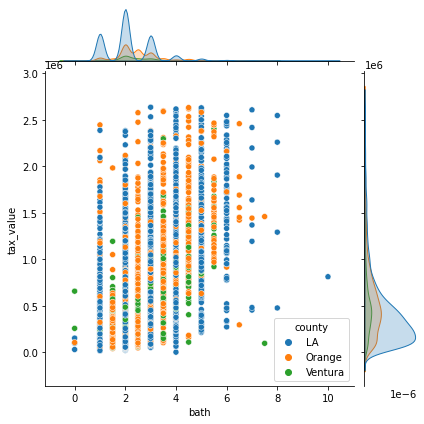

In [24]:
sns.jointplot(x = 'bath', y = 'tax_value', data = train, hue = 'county')

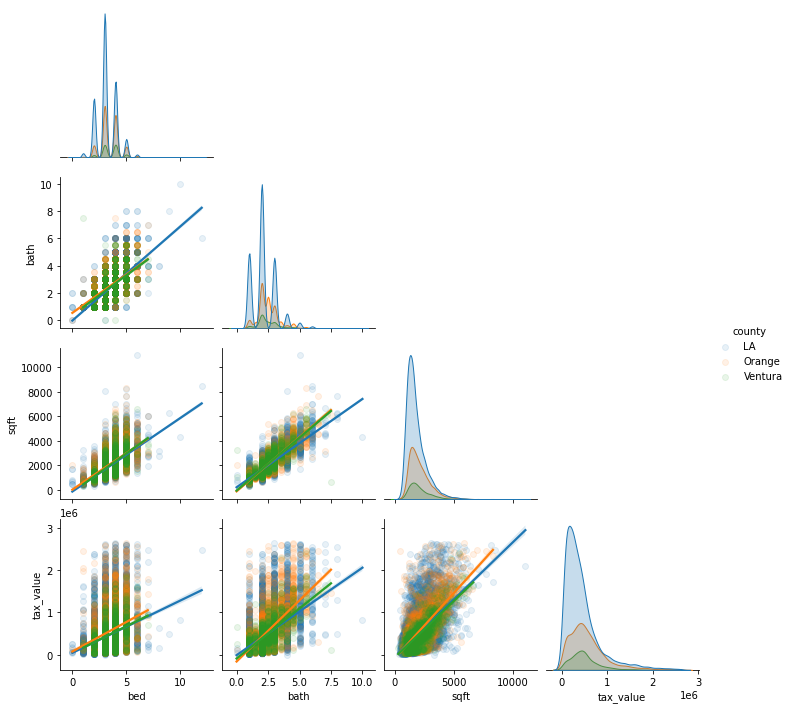

In [25]:
sns.pairplot(train[['bed','bath','sqft','tax_value','county']], hue = 'county',kind="reg",plot_kws={ 'scatter_kws': {'alpha': 0.1}}, corner = True)

In [26]:
train['mean_baseline'] = train['tax_value'].mean()
train['med_baseline'] = train['tax_value'].median()

In [27]:
evaluate.baseline_mean_errors(train['tax_value'])

|Sum of Squared Errors: 2.567e+15
|-----------------------------------
|Mean Squared Error : 1.66e+11
|-----------------------------------
|Root Mean Squared Error : 4.074e+05


(None, None, None, None, None)

In [28]:
evaluate.baseline_median_errors(train['tax_value'])

|Sum of Squared Errors: 2.718e+15
|-----------------------------------
|Mean Squared Error : 1.757e+11
|-----------------------------------
|Root Mean Squared Error : 4.192e+05


(None, None, None, None, None)

In [29]:
# mean works better for the baseline


In [30]:
X_train_scaled

,bed,bath,sqft,county
0,0.250000,0.20,0.162127,LA
1,0.333333,0.40,0.211660,LA
2,0.333333,0.30,0.132649,LA
3,0.250000,0.30,0.166884,LA
4,0.333333,0.25,0.220522,Orange
...,...,...,...,...
15460,0.333333,0.30,0.207183,LA
15461,0.250000,0.10,0.092724,LA
15462,0.250000,0.40,0.239739,LA
15463,0.250000,0.30,0.114925,LA


In [31]:
# going to go with a polynomial model due to target distribution
# make the polynomial features to get a new set of features
pf = sklearn.preprocessing.PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled[['bed','bath','sqft']])

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled[['bed','bath','sqft']])
X_test_degree2 = pf.transform(X_test_scaled[['bed','bath','sqft']])

In [32]:
lm = LinearRegression(normalize=True)

lm.fit(X_train_degree2, y_train.tax_value)
y_train['pred_lm'] = lm.predict(X_train_degree2)
rmse_train = mean_squared_error(y_train.tax_value, y_train.pred_lm)**(1/2)

y_validate['pred_lm'] = lm.predict(X_validate_degree2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  314121.59728373145 
Validation/Out-of-Sample:  314393.9826546377


In [33]:
evaluate.regression_stats(y_train.tax_value, y_train.pred_lm)

|Slope of Regression: 0.4055
|-----------------------------------
|Regression intercept: 2.806e+05
|-----------------------------------
|r² = 0.41
|-----------------------------------
|p value = 0.0
|-----------------------------------
|Standard error : 0.003948


(None, None, None, None, None, None, None, None, None)

In [34]:
lars = LassoLars(alpha=1.0)
lars.fit(X_train_scaled[['bed','bath','sqft']], y_train.tax_value)
y_train['pred_lars'] = lars.predict(X_train_scaled[['bed','bath','sqft']])
rmse_train = mean_squared_error(y_train.tax_value, y_train.pred_lars)**(1/2)
y_validate['pred_lars'] = lars.predict(X_validate_scaled[['bed','bath','sqft']])
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  317591.49729632493 
Validation/Out-of-Sample:  316867.1518586373


In [35]:
evaluate.regression_stats(y_train.tax_value, y_train.pred_lars)

|Slope of Regression: 0.392
|-----------------------------------
|Regression intercept: 2.869e+05
|-----------------------------------
|r² = 0.39
|-----------------------------------
|p value = 0.0
|-----------------------------------
|Standard error : 0.003924


(None, None, None, None, None, None, None, None, None)

In [36]:
stats.normaltest(y_train.tax_value)

NormaltestResult(statistic=6096.235448193138, pvalue=0.0)

In [37]:
glm = TweedieRegressor(power=0, alpha=0)
glm.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['pred_glm'] = glm.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.pred_glm)**(1/2)

# predict validate
y_validate['pred_glm'] = glm.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  314677.30103290593 
Validation/Out-of-Sample:  314139.6541759732


In [38]:
evaluate.regression_stats(y_train.tax_value, y_train.pred_glm)

|Slope of Regression: 0.4032
|-----------------------------------
|Regression intercept: 2.818e+05
|-----------------------------------
|r² = 0.4
|-----------------------------------
|p value = 0.0
|-----------------------------------
|Standard error : 0.003943


(None, None, None, None, None, None, None, None, None)

In [39]:
# polynomial regression model works the best.

<AxesSubplot:title={'center':'Actual vs Baseline Residual'}, xlabel='actual value ($y$)', ylabel='residual ($baseline_y - \\hat{y}$)'>

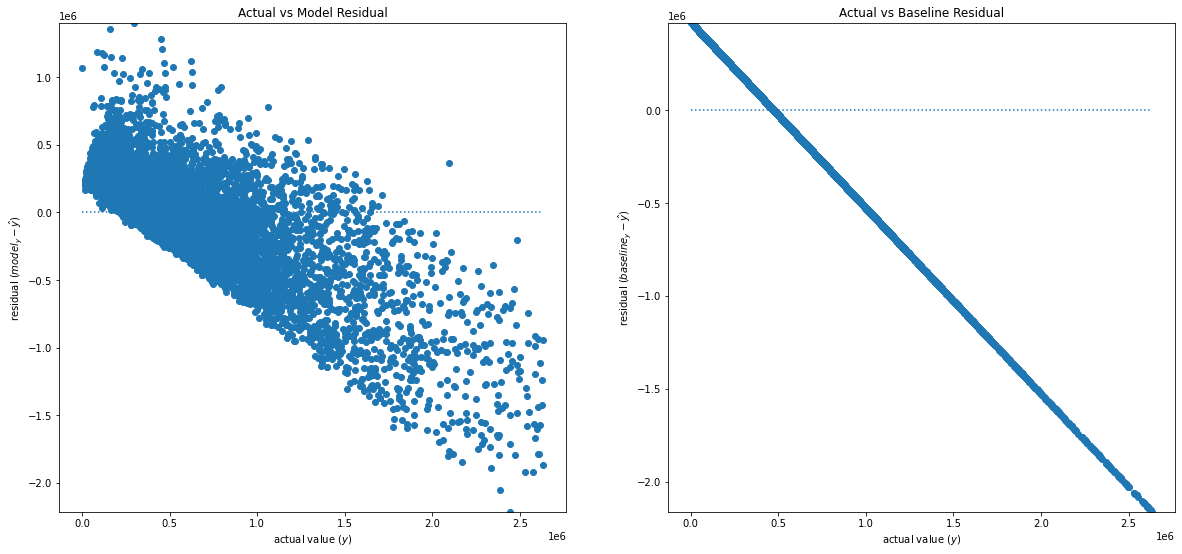

In [40]:
evaluate.plot_res(y_train.tax_value, y_train.pred_lm)

In [45]:
evaluate.better_than_baseline(y_train.tax_value, y_train.pred_lm)

,metric,model_error,base_error,model_efficacy
0,SSE,1.525968e+15,2.566729e+15,True
1,MSE,9.867238e+10,1.659702e+11,True
2,RMSE,3.141216e+05,4.073944e+05,True


In [41]:
evaluate.better_than_baseline(y_validate.tax_value, y_validate.pred_lm)

,metric,model_error,base_error,model_efficacy
0,SSE,6.551352e+14,1.098350e+15,True
1,MSE,9.884358e+10,1.657136e+11,True
2,RMSE,3.143940e+05,4.070794e+05,True


In [43]:
lm = LinearRegression(normalize=True)

lm.fit(X_test_degree2, y_test.tax_value)
y_test['pred_lm'] = lm.predict(X_test_degree2)
rmse_test = mean_squared_error(y_test.tax_value, y_test.pred_lm)**(1/2)

print("RMSE for Polynomial Regression on Test: ", rmse_test)

RMSE for Polynomial Regression on Test:  319994.21381415956


In [44]:
evaluate.better_than_baseline(y_test.tax_value, y_test.pred_lm)

,metric,model_error,base_error,model_efficacy
0,SSE,5.656371e+14,9.476542e+14,True
1,MSE,1.023963e+11,1.715522e+11,True
2,RMSE,3.199942e+05,4.141886e+05,True
